# Change point detection

Change point detection is the task of finding changes in the underlying model of a signal or time
series.

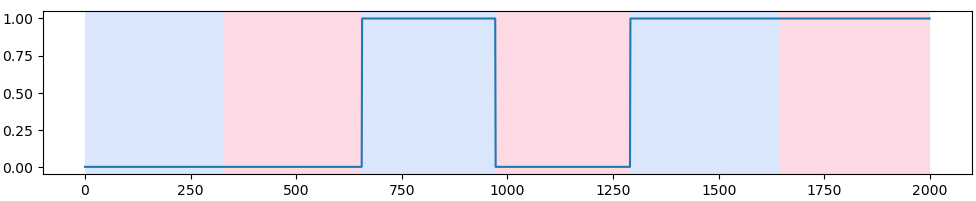

Change point detection methods are divided into two main branches: online methods, that aim to
detect changes as soon as they occur in a real-time setting, and offline methods that retrospectively
detect changes when all samples are received. The former task is often referred to as event or anomaly
detection, while the latter is sometimes called signal segmentation.

## Problem formulation
You find the best $T$ which is a collection of points $\{t_1, t_2, ... t_K\}$

and minimise the following

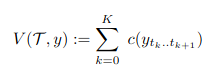


$c(\cdot)$ is a cost function which measures goodness-of-fit of the sub-signal $y_{t_k..t_{k+1}} = \{y_t\}_{t=t_k+1}^{t_{k+1}}$.

**Problem 1**: known number of changes *K*. The change point detection problem with a fixed number *K* of change points consists in solving the following discrete optimization problem
$$
\min_{|T| = K} V(T). \quad (P1)
$$
**Problem 2**: unknown number of changes. The change point detection problem with an unknown number of change points consists in solving the following discrete optimization problem
$$
\min_{T} V(T) + pen(T) \quad (P2)
$$



* **Cost function**. The cost function $c(\cdot)$ is a measure of **"homogeneity"**. Its choice encodes the type of changes that can be detected. Intuitively, $c(y_{a..b})$ is expected to be **low if the sub-signal $y_{a..b}$ is "homogeneous"** (meaning that it does not contain any change point), and **large if the sub-signal $y_{a..b}$ is "heterogeneous"** (meaning that it contains one or several change points).
* **Search method.** The search method is the resolution procedure for the discrete optimization problems associated with **Problem 1 (P1)** and **Problem 2 (P2)**. The literature contains several methods to efficiently solve those problems, in an **exact fashion** or in an **approximate fashion**. Each method strikes a balance between **computational complexity** and **accuracy**.
* **Constraint (on the number of change points).** When the number of changes is unknown (**Problem 2 (P2)**), a constraint is added, in the form of a **complexity penalty** $pen(·)$, to balance out the **goodness-of-fit term** $V(T, y)$. The choice of the complexity penalty is related to the amplitude of the changes to detect: with too "small" a penalty (compared to the goodness-of-fit) in **(P2)**, many change points are detected, even those that are the result of noise. Conversely, too much penalization only detects the most significant changes, or even none.

## Cost function

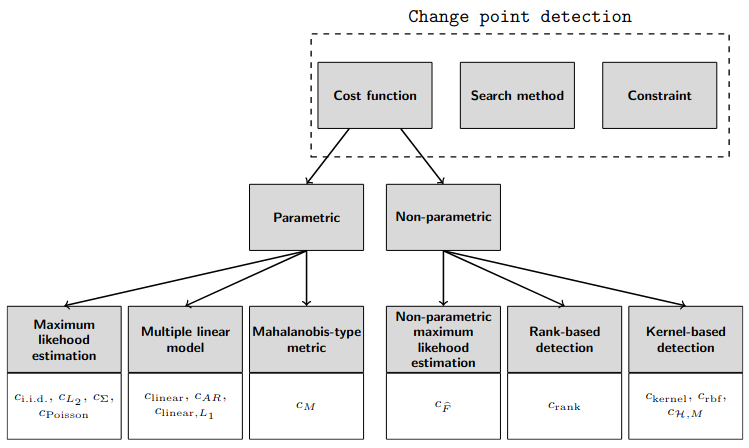

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import ipywidgets as widgets
from ipywidgets import interact
import ruptures as rpt
from ruptures.metrics import hausdorff

In [47]:
from ruptures.metrics import meantime

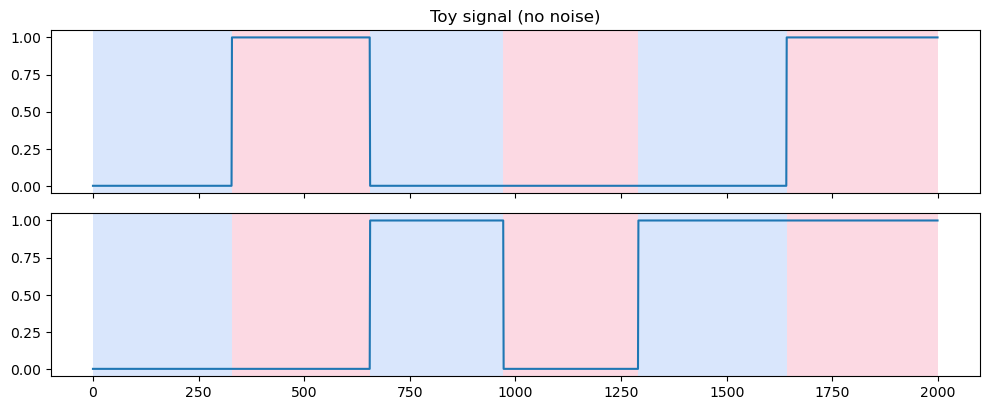

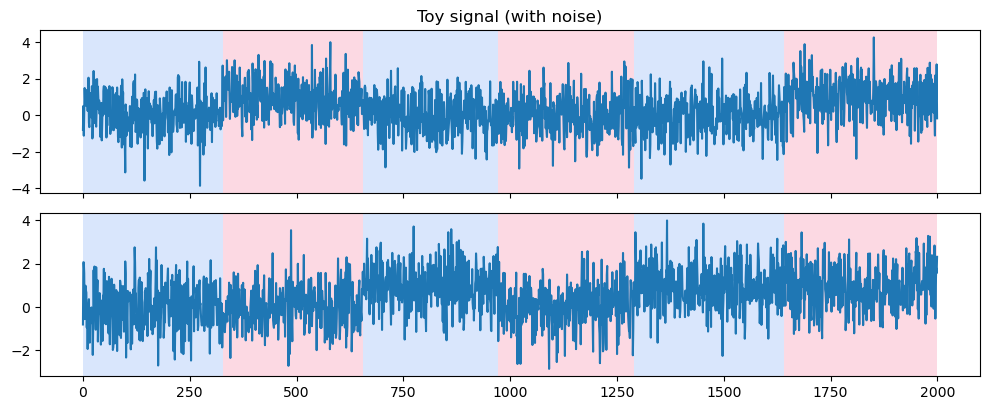

In [43]:
signal_no_noise = np.array([[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0]])
# fmt: on
bkps_on_dim_0 = [329, 656, 1642, 2000]
bkps_on_dim_1 = [656, 972, 1291, 2000]
bkps_all_dims = [329, 656, 972, 1291, 1642, 2000]

signal_with_noise = signal_no_noise + np.random.normal(scale=1,size=signal_no_noise.shape)

fig, axes = rpt.display(signal_no_noise, bkps_all_dims)
_ = axes[0].set_title("Toy signal (no noise)")

fig, axes = rpt.display(signal_with_noise, bkps_all_dims)
_ = axes[0].set_title("Toy signal (with noise)")

Hausdorff Metric: 28.0
Meantime Metric: 11.0


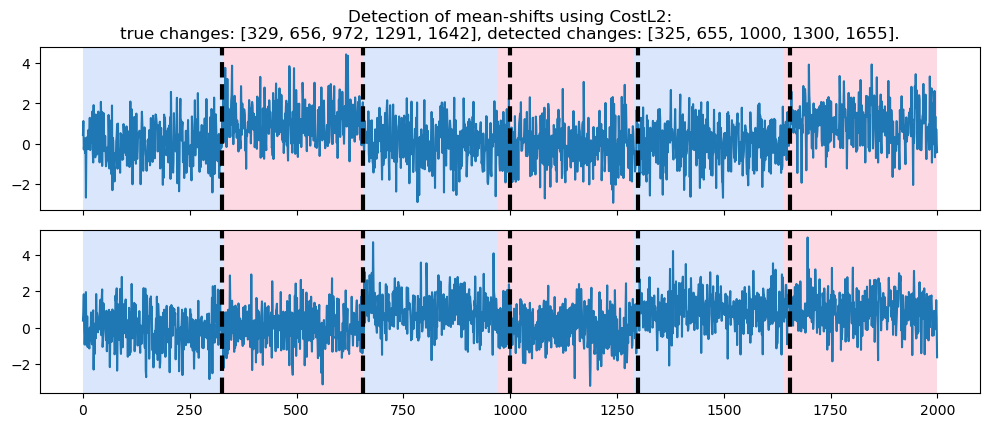

In [49]:
signal_with_noise = signal_no_noise + np.random.normal(scale=1,size=signal_no_noise.shape)

cost_function = rpt.costs.CostL2()
algo_on_dim_0 = rpt.Dynp(custom_cost=cost_function).fit(
    signal_with_noise
)
bkps_pred = algo_on_dim_0.predict(
    n_bkps=len(bkps_all_dims) - 1
)  # the number of changes is known
# display signal and changes
fig, axes = rpt.display(signal_with_noise, bkps_all_dims, bkps_pred)
_ = axes[0].set_title(
    (
        f"""Detection of mean-shifts using CostL2:\n"""
        f"""true changes: {bkps_all_dims[:-1]}, detected changes: {bkps_pred[:-1]}."""
    )
)
print(f"Hausdorff Metric: {hausdorff(bkps_pred, bkps_all_dims)}")
print(f"Meantime Metric: {meantime(bkps_all_dims, bkps_pred)}")



## Search methods

**Optimal detection methods** aim to find the *exact* solutions for **Problem 1 (P1)** and **Problem 2 (P2)**. A straightforward, but inefficient, approach involves checking *all* possible segmentations of a signal and selecting the one that minimizes the objective function. 

However, this exhaustive approach is impractical because of the sheer number of possibilities:

*   For **Problem 1 (P1)**, where the number of change points *K* is known, the minimization must be performed over the set of segmentations *T* where the number of change points is equal to *K*, denoted as {*T* s.t. |*T*| = *K*}. This set contains $\binom{T-1}{K-1}$ elements.

*   For **Problem 2 (P2)**, where the number of change points is unknown, the minimization is over the set of all segmentations *T* such that the number of change points is between 1 and *T*-1, denoted as {*T* s.t. 1 ≤ |*T*| < *T*}. This set includes $\sum_{K=1}^{T-1} \binom{T-1}{K-1}$ elements.

Because of the large number of possible segmentations, exhaustive enumeration is computationally infeasible for both **Problem 1** and **Problem 2**. Therefore, more efficient methods are needed to find the exact solutions. The source then introduces two major approaches to efficiently solve **P1** and **P2**.

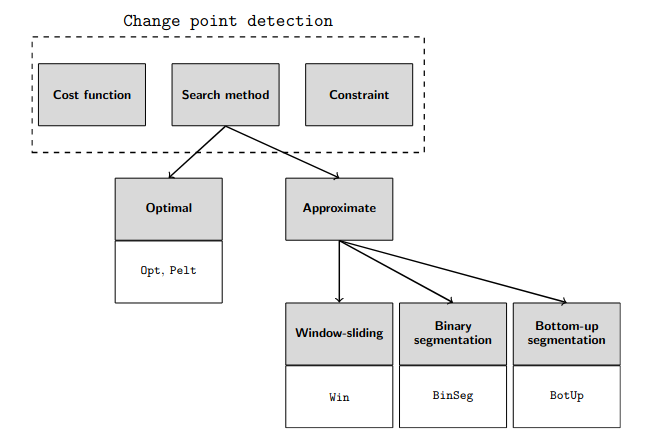

### Dynamic Programming

Since the cost is additive in nature, You can do the following

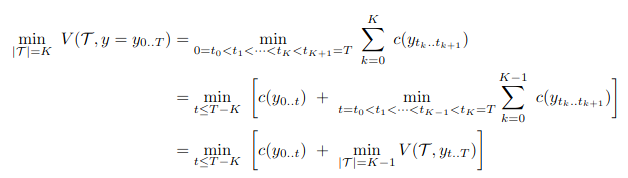

this problem is now just finding one optimal point $t$ for the above problem

Hausdorff Metric: 28.0
Meantime Metric: 11.0


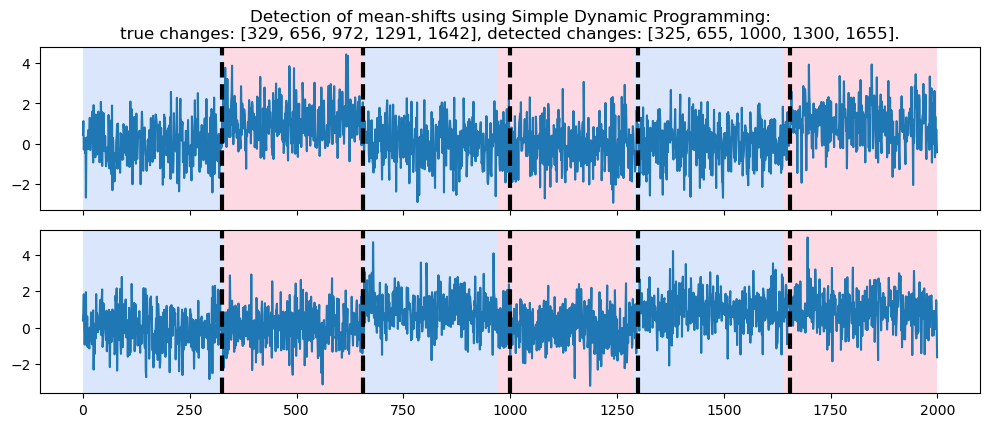

In [50]:
algo_on_dim_0 = rpt.Dynp().fit(
    signal_with_noise
)
bkps_pred = algo_on_dim_0.predict(
    n_bkps=len(bkps_all_dims) - 1
)  # the number of changes is known
# display signal and changes
fig, axes = rpt.display(signal_with_noise, bkps_all_dims, bkps_pred)
_ = axes[0].set_title(
    (
        f"""Detection of mean-shifts using Simple Dynamic Programming:\n"""
        f"""true changes: {bkps_all_dims[:-1]}, detected changes: {bkps_pred[:-1]}."""
    )
)
print(f"Hausdorff Metric: {hausdorff(bkps_pred, bkps_all_dims)}")
print(f"Meantime Metric: {meantime(bkps_all_dims, bkps_pred)}")


## Window-based Search

For a given cost function $c(\cdot)$, the discrepancy between two sub-signals is given by:

$d(y_{a..t}, y_{t..b}) = c(y_{a..b}) - c(y_{a..t}) - c(y_{t..b})$  (where $1 \leq a < t < b \leq T$)

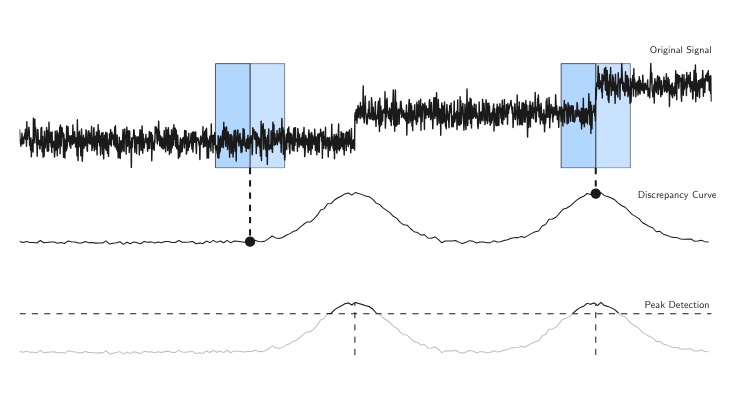

In [51]:
def plot_interactive(scale=0.25):
    signal_with_noise = signal_no_noise + np.random.normal(scale=scale,size=signal_no_noise.shape)
    algo_on_dim_0 = rpt.Window().fit(
        signal_with_noise
    )
    bkps_pred = algo_on_dim_0.predict(
        n_bkps=len(bkps_all_dims) - 1
    )  # the number of changes is known
    # display signal and changes
    fig, axes = rpt.display(signal_with_noise, bkps_all_dims, bkps_pred)
    _ = axes[0].set_title(
        (
            f"""Detection of mean-shifts using Window-based search and scale: {scale:0.1f}\n"""
            f"""true changes: {bkps_all_dims[:-1]}, detected changes: {bkps_pred[:-1]}."""
        )
    )
    print(f"Hausdorff Metric: {hausdorff(bkps_pred, bkps_all_dims)}")
    print(f"Meantime Metric: {meantime(bkps_all_dims, bkps_pred)}")

interact(plot_interactive,
         scale=widgets.Dropdown(options=[0.125, 0.25, 0.5, 1, 2, 4], value=1, description='Scale'))

interactive(children=(Dropdown(description='Scale', index=3, options=(0.125, 0.25, 0.5, 1, 2, 4), value=1), Ou…

<function __main__.plot_interactive(scale=0.25)>

### Binary Segmentation

A simple and important example of greedy6 partition is binary segmentation. Its idea
is to construct the partition in a recursive way: searching for a single splitting point,
then dividing the data into two parts, and applying this procedure to each part. This
recursive procedure often needs to be repeated many times (cf. Algorithm 1). It is
a special instance of a more general scheme underlying many statistical and machine
learning procedures.


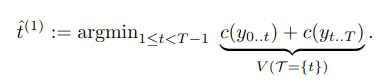

In [52]:
def plot_interactive(scale=0.25):
    signal_with_noise = signal_no_noise + np.random.normal(scale=scale,size=signal_no_noise.shape)
    algo_on_dim_0 = rpt.Binseg(model = "l2").fit(
        signal_with_noise
    )
    bkps_pred = algo_on_dim_0.predict(
        n_bkps=len(bkps_all_dims) - 1
    )  # the number of changes is known
    # display signal and changes
    fig, axes = rpt.display(signal_with_noise, bkps_all_dims, bkps_pred)
    _ = axes[0].set_title(
        (
            f"""Detection of mean-shifts using BinSeg-based search and scale: {scale:0.1f}\n"""
            f"""true changes: {bkps_all_dims[:-1]}, detected changes: {bkps_pred[:-1]}."""
        )
    )
    print(f"Hausdorff Metric: {hausdorff(bkps_pred, bkps_all_dims)}")
    print(f"Meantime Metric: {meantime(bkps_all_dims, bkps_pred)}")

interact(plot_interactive,
         scale=widgets.Dropdown(options=[0.125, 0.25, 0.5, 1, 2, 4], value=1, description='Scale'))

interactive(children=(Dropdown(description='Scale', index=3, options=(0.125, 0.25, 0.5, 1, 2, 4), value=1), Ou…

<function __main__.plot_interactive(scale=0.25)>

## Change-point analysis on real data

In [2]:
df = pd.read_csv('us_covid19_daily.csv')
df.head()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,lastModified,total,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
0,20201206,56,14534035,161986294,13592.0,101487.0,585676.0,20145.0,31946.0,7094.0,...,204063869,2020-12-06T24:00:00Z,0,0,1138,2256,1172590,176771,1634532,9cf16504f91958e803a2197daf8c2528a4eddc18
1,20201205,56,14357264,160813704,13433.0,101190.0,583420.0,19950.0,31831.0,7005.0,...,202429337,2020-12-05T24:00:00Z,0,0,2445,3316,1526995,211073,2169756,6249216c5f097c94ce33a811dab011a483a42404
2,20201204,56,14146191,159286709,12714.0,101276.0,580104.0,19858.0,31608.0,6999.0,...,200259581,2020-12-04T24:00:00Z,0,0,2563,4652,1260657,224831,1854869,ae30ea088584335ba4d57ee927f8dbda6add74db
3,20201203,56,13921360,158026052,15106.0,100755.0,575452.0,19723.0,31276.0,6867.0,...,198404712,2020-12-03T24:00:00Z,0,0,2706,5331,1238465,210204,1828230,0f253d185ecb336cdd18a4c61996eda1b7eef13b
4,20201202,56,13711156,156787587,14368.0,100322.0,570121.0,19680.0,31038.0,6855.0,...,196576482,2020-12-02T24:00:00Z,0,0,2733,5028,982032,195796,1459202,477c17b6302d0485195e77ecf8270a974f7a3c82


In [3]:
df.columns

Index(['date', 'states', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'dateChecked', 'death', 'hospitalized', 'totalTestResults',
       'lastModified', 'total', 'posNeg', 'deathIncrease',
       'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease',
       'totalTestResultsIncrease', 'hash'],
      dtype='object')

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.sort_values('date', inplace=True)  # Sort by date
df.reset_index(drop=True, inplace=True)

In [5]:
df['daily_cases'] = df['positive'].diff()
df.dropna(subset=['daily_cases'], inplace=True)

In [6]:

def print_breakpoints(model_param=10, data_transform="Normal", algo_type='Pelt'):
    time_series = None
    if data_transform == "Rolling":
        time_series = df['daily_cases'].rolling(window=7).mean()
        time_series = time_series.dropna()
        time_series = time_series.values
    elif data_transform == "LogTransform":
        time_series = np.log(df['daily_cases'] + 1).values
    else:
        time_series = df['daily_cases'].values

    # Fit the Pelt model
    if algo_type == "Dynp":
        algo = rpt.Dynp(model="l2").fit(time_series)
        breakpoints = algo.predict(n_bkps=model_param)
    else:
        algo = rpt.Pelt(model='rbf').fit(time_series)
        breakpoints = algo.predict(pen=model_param)
    
    
    # print(f"Breakpoints at model_param={model_param:2d}:", breakpoints)
    # for bkp in breakpoints[:-1][:10]:  # the last breakpoint is usually end of the series
    #     date_of_change = df.iloc[bkp].date
    #     print(f"Detected change at index {bkp}, date = {date_of_change}")

    print(f"Hausdorff Metric: {hausdorff(bkps_pred, bkps_all_dims)}")
    rpt.display(time_series, breakpoints, figsize=(10, 6))
    plt.title("Changepoint Detection on Daily New COVID-19 Cases (U.S.)")
    plt.xlabel("Time Index")
    plt.ylabel("Daily Cases")
    plt.show()

data_transform = widgets.Dropdown(
    options=['Normal', 'Rolling', 'LogTransform'],
    value='Normal',
    description='Data Transform'
)

algo_type = widgets.Dropdown(
    options=['Pelt', 'Dynp'],
    value='Pelt',
    description='Algorithm used'
)


interact(print_breakpoints, 
         model_param=widgets.IntSlider(value=10, min=1, max=50, step=1, description='Model Parameter'),
         data_transform=data_transform,
         algo_type=algo_type,
         )

interactive(children=(IntSlider(value=10, description='Model Parameter', max=50, min=1), Dropdown(description=…

<function __main__.print_breakpoints(model_param=10, data_transform='Normal', algo_type='Pelt')>

Breakpoints: [50, 145, 270, 300]
Detected change at index 50, date = 2020-03-13 00:00:00
Detected change at index 145, date = 2020-06-16 00:00:00
Detected change at index 270, date = 2020-10-19 00:00:00


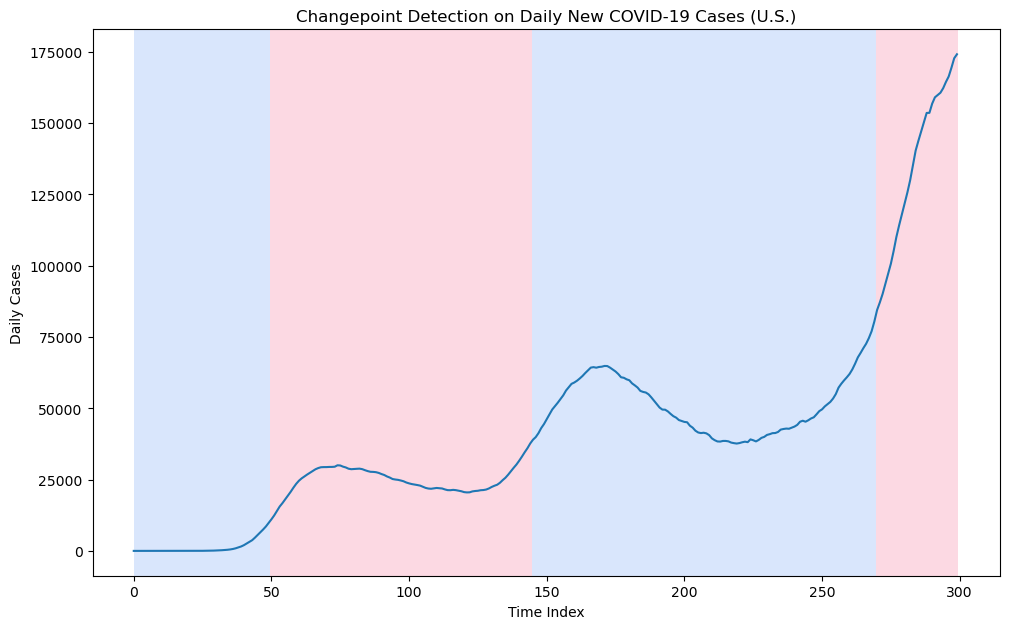

In [69]:
time_series = df['daily_cases'].rolling(window=20, center=True).mean()
time_series = time_series.dropna()
time_series = time_series.values
# time_series = df['daily_cases'].values

algo = rpt.Pelt(model='rbf').fit(time_series)
breakpoints = algo.predict(pen=20)

print(f"Breakpoints:", breakpoints)
for bkp in breakpoints[:-1][:10]:  # the last breakpoint is usually end of the series
    date_of_change = df.iloc[bkp].date
    print(f"Detected change at index {bkp}, date = {date_of_change}")


rpt.display(time_series, breakpoints, figsize=(10, 6))
plt.title("Changepoint Detection on Daily New COVID-19 Cases (U.S.)")
plt.xlabel("Time Index")
plt.ylabel("Daily Cases")
plt.show()

In [52]:
algo = rpt.Pelt(model='rbf').fit(df['daily_cases'].rolling(window=20, center=True).mean().values - df['daily_cases'].rolling(window=20).mean().values)
breakpoints = algo.predict(pen=100)
print(f"Breakpoints:", breakpoints)


Breakpoints: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 319]


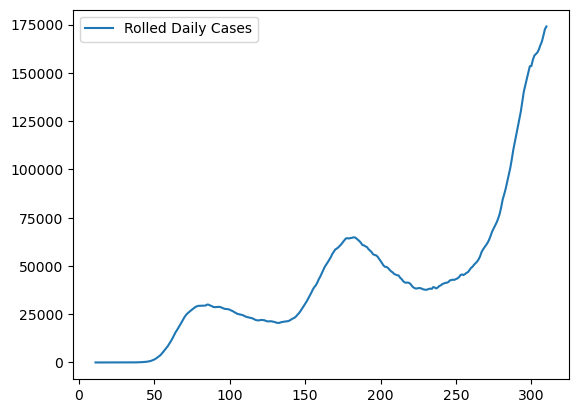

In [68]:
rolled_series = df['daily_cases'].rolling(window=20, center=True).mean()
rolled_series = rolled_series.dropna()  # remove the edges that are NaN
plt.plot(rolled_series, label='Rolled Daily Cases')
plt.legend()
plt.show()

References:

* C. Truong, L. Oudre, N. Vayatis. Selective review of offline change point detection methods. Signal Processing, 167:107299, 2020